# Reducing Bias in Machine Learning Models:
### Modeling Part 1: Vanilla Models (Basic and Optimized)


#### Kristen Lo - BrainStation
---

### Table of Contents
- [Introduction](#intro)
- [Part 3: Vanilla Models (Basic and Optimized)](#clean)
    - 1.1: [Housekeeping](#house)
    - 1.2: [Logistic Regression](#log)
    - 1.3: [Decision Tree](#tree)
- [Conclusion](#conc)


---
### <a id = 'intro'></a> Introduction

In this notebook, we will be preparing our vanilla model and then optimizing it for performance. 

There is a need to be able to predict the hospital admission rates for diabetic patients. However, using traditional machine learning models can lead to health disparities caused by biased data which can be related to demographic data (ex. race, age, income, insurance etc). These biases need to be removed prior to modelling so that bias isn't introduced into the model. Building on the work of Raza, S. who aimed to predict, diagnose, and mitigate health disparities in hospital re-admission, my aim is to replicate the study performed by Raza and create my own model that's able to screen for biases and predict admission rates for diabetics visiting the ER. 


Data was sourced from all adult Emergency Department visits from March 2014 - July 2017 from one academic and two community emergency rooms, apart from the Yale New Haven Health system. These visits resulted in either admission to their respective hospital or discharge. 

There are a total of 972 variables that we extracted per patient visit from 560,486 patient visits. 

Courtesy of:
 "Hong WS, Haimovich AD, Taylor RA (2018) Predicting hospital admission at emergency department triage using machine learning. PLoS ONE 13(7): e0201016." (https://doi.org/10.1371/journal.pone.0201016)




-----

## <a id = 'clean'></a> Part 3: Vanilla Modelling (Basic and Optimized) 

---
#### <a id = 'housekeeping'></a> 1.1 HouseKeeping 

Loading the necessary libraries

In [131]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, f1_score
)
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.model_selection import StratifiedKFold, cross_val_score

Loading the clean csv file

In [132]:
health_data = pd.read_csv('Data/clean_health_data_pt2.csv')

In [133]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None) #Show all rows

In [134]:
health_data.head()

,demo_gender,demo_race,disposition,pmh_2ndarymalig,pmh_abdomhernia,pmh_acqfootdef,pmh_acrenlfail,pmh_acutecvd,pmh_acutemi,pmh_acutphanm,pmh_adltrespfl,pmh_alcoholrelateddisorders,pmh_amniosdx,pmh_anemia,pmh_aneurysm,pmh_anxietydisorders,pmh_artembolism,pmh_asppneumon,pmh_asthma,pmh_attentiondeficitconductdisruptivebeha,pmh_biliarydx,pmh_bladdercncr,pmh_blindness,pmh_bnignutneo,pmh_bonectcncr,pmh_bph,pmh_brainnscan,pmh_breastcancr,pmh_breastdx,pmh_brnchlngca,pmh_cardiaarrst,pmh_carditis,pmh_cataract,pmh_chfnonhp,pmh_chrkidneydisease,pmh_coaghemrdx,pmh_coloncancer,pmh_comabrndmg,pmh_complicdevi,pmh_complicproc,pmh_conduction,pmh_contraceptiv,pmh_copd,pmh_coronathero,pmh_crushinjury,pmh_cysticfibro,pmh_deliriumdementiaamnesticothercognitiv,pmh_developmentaldisorders,pmh_diabmelnoc,pmh_diabmelwcm,pmh_disordersusuallydiagnosedininfancych,pmh_diverticulos,pmh_dizziness,pmh_dminpreg,pmh_dysrhythmia,pmh_ecodesadverseeffectsofmedicalcare,pmh_ecodesfall,pmh_ecodesfirearm,pmh_ecodesmotorvehicletrafficmvt,pmh_ecodesotherspecifiedandclassifiable,pmh_encephalitis,pmh_endometrios,pmh_epilepsycnv,pmh_esophcancer,pmh_esophgealdx,pmh_eyeinfectn,pmh_femgenitca,pmh_feminfertil,pmh_fluidelcdx,pmh_fuo,pmh_fxarm,pmh_fxhip,pmh_fxskullfac,pmh_gangrene,pmh_gasduoulcer,pmh_gastritis,pmh_gastroent,pmh_giconganom,pmh_gihemorrhag,pmh_giperitcan,pmh_glaucoma,pmh_goutotcrys,pmh_guconganom,pmh_hdnckcancr,pmh_headachemig,pmh_hemorrpreg,pmh_hodgkinsds,pmh_hrtvalvedx,pmh_htn,pmh_htncomplicn,pmh_htninpreg,pmh_hyperlipidem,pmh_immunitydx,pmh_inducabortn,pmh_infectarth,pmh_influenza,pmh_infmalegen,pmh_intestinfct,pmh_intobstruct,pmh_intracrninj,pmh_jointinjury,pmh_kidnyrnlca,pmh_lateeffcvd,pmh_leukemias,pmh_liveribdca,pmh_lowbirthwt,pmh_lungexternl,pmh_lymphenlarg,pmh_maintchemr,pmh_maligneopls,pmh_meningitis,pmh_menstrualdx,pmh_miscellaneousmentalhealthdisorders,pmh_mooddisorders,pmh_mouthdx,pmh_ms,pmh_multmyeloma,pmh_mycoses,pmh_neoplsmunsp,pmh_nephritis,pmh_nonepithca,pmh_nonhodglym,pmh_nutritdefic,pmh_opnwndextr,pmh_osteoarthros,pmh_osteoporosis,pmh_otaftercare,pmh_otbnignneo,pmh_otbonedx,pmh_otcirculdx,pmh_otcomplbir,pmh_otconntiss,pmh_otdxbladdr,pmh_otdxkidney,pmh_otdxstomch,pmh_otendodsor,pmh_otfemalgen,pmh_othbactinf,pmh_othcnsinfx,pmh_othematldx,pmh_othercvd,pmh_othereardx,pmh_otheredcns,pmh_othereyedx,pmh_othergidx,pmh_othergudx,pmh_otherinjury,pmh_otherpregnancyanddeliveryincludingnormal,pmh_otherscreen,pmh_othfracture,pmh_othheartdx,pmh_othliverdx,pmh_othlowresp,pmh_othmalegen,pmh_othnervdx,pmh_othveindx,pmh_otinflskin,pmh_otitismedia,pmh_otjointdx,pmh_otnutritdx,pmh_otprimryca,pmh_otrespirca,pmh_otupprresp,pmh_otuprspin,pmh_ovariancyst,pmh_pancreascan,pmh_pancreasdx,pmh_paralysis,pmh_parkinsons,pmh_pathologfx,pmh_peripathero,pmh_peritonitis,pmh_personalitydisorders,pmh_phlebitis,pmh_pid,pmh_pleurisy,pmh_pneumonia,pmh_poisnotmed,pmh_precereoccl,pmh_prevcsectn,pmh_prolapse,pmh_prostatecan,pmh_pulmhartdx,pmh_rctmanusca,pmh_rehab,pmh_respdistres,pmh_retinaldx,pmh_rheumarth,pmh_schizophreniaandotherpsychoticdisorde,pmh_screeningandhistoryofmentalhealthan,pmh_septicemia,pmh_sexualinfxs,pmh_shock,pmh_sicklecell,pmh_skininfectn,pmh_skinmelanom,pmh_socialadmin,pmh_spincorinj,pmh_stomchcancr,pmh_substancerelateddisorders,pmh_suicideandintentionalselfinflictedin,pmh_superficinj,pmh_syncope,pmh_teethdx,pmh_testiscancr,pmh_thyroiddsor,pmh_tia,pmh_tonsillitis,pmh_ulceratcol,pmh_ulcerskin,pmh_unclassified,pmh_urinyorgca,pmh_uteruscancr,pmh_uti,pmh_varicosevn,pmh_viralinfect,pmh_whtblooddx,cc_abdominalcramping,cc_abdominaldistention,cc_abdominalpain,cc_abdominalpainpregnant,cc_abnormallab,cc_abscess,cc_addictionproblem,cc_alcoholintoxication,cc_alcoholproblem,cc_allergicreaction,cc_alteredmentalstatus,cc_animalbite,cc_ankleinjury,cc_anklepain,cc_anxiety,cc_arminjury,cc_armpain,cc_assaultvictim,cc_asthma,cc_backpain,cc_bleeding/bruising,cc_bodyfluidexposure,cc_breastpain,cc_breathingdifficulty,cc_burn,cc_cardiacarrest,cc_chestpain,cc_coldlikesymptoms,cc_confusion,cc_co

In [135]:
health_data.shape

(105627, 443)

In [136]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 443 entries, demo_gender to dum_huse__3-plus_hormones
dtypes: int64(443)
memory usage: 357.0 MB


Considering that all of the information is binary, int64 dtype is bloating the file unnecessarily. Let's convert it to int8 to conserve memory and assist in modeling.

In [137]:
# Assuming df is your DataFrame
int64_columns = health_data.select_dtypes(include='int64').columns

# Convert selected columns to int8
health_data[int64_columns] = health_data[int64_columns].astype('int8')

In [138]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 443 entries, demo_gender to dum_huse__3-plus_hormones
dtypes: int8(443)
memory usage: 44.6 MB


As we can see, the memory usage has decreased from 357 mb to 44.6mb. This should be less computationally intensive.

---
#### <a id = 'log'></a> 1.2 Logistic Regression 

Before we can use Log regression, we must make sure that this data satisfies the assumptions. First is to double check if any multicolinearity exists within the data set. 

In [139]:
# Record time
start_time = time.time()

#  Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Split to train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for multicollinearity
corr_matrix = X_train.corr()

# Identify highly correlated features
highly_correlated = np.where(np.abs(corr_matrix) > 0.7)

# Show the highly correlated features
features_to_drop = set()
for col1, col2 in zip(*highly_correlated):
    if col1 != col2 and col1 not in features_to_drop:
        features_to_drop.add(col2)
        print(f"Highly correlated features: {X_train.columns[col1]} and {X_train.columns[col2]}")

# Record time
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time
print("Runtime: {:.2f} seconds".format(runtime))


Highly correlated features: dum_triage_vital__no_hr_recorded and dum_triage_vital__no_rr_recorded
Highly correlated features: dum_triage_vital__no_hr_recorded and dum_triage_vital__no_temp_recorded
Highly correlated features: dum_huse__no_prior_visits and dum_hist_glucose_median__no_glucose_level_recorded
Highly correlated features: dum_huse__No_prior_admis and dum_hist_glucose_median__no_glucose_level_recorded
Runtime: 27.29 seconds


So there is multicolinearity that exists within the data set, but this makes sense. If a patient didn't have one `triage vital` recorded then it's highly unlikely that they would have the others since triage assessments are all done at the same time. From doing a little bit of digging, it was found that patients that arrive in emergent situations usually don't have `triage vitals` recorded as they are either rushed in by ambulance or taken quickly to treatment. 

Also the glucose level is the last lab value from a previous visit, so it makes sense why no prior admissions and no prior visits would be highly correlated to no glucose level In order to satisfy the assumptions, I will drop these columns from the original data frame. 

In [140]:
features_to_drop = [
    'dum_triage_vital__no_hr_recorded','dum_triage_vital__no_rr_recorded','dum_triage_vital__no_temp_recorded',
    'dum_huse__no_prior_visits','dum_huse__No_prior_admis', 'dum_hist_glucose_median__no_glucose_level_recorded'
]

#drop from the original data frame. 
health_data = health_data.drop(columns=features_to_drop)

Now to begin Logistic Regression, I will first run a baseline model with no modifications. I will not scale the data as this is unnecessary for a dataset that is made up of only binary values. However, if it was a different data set, I would scale it as per standard practice. I will include the evaluations for the model as well in the code.

Cross-Validation Scores: [0.7848648  0.78893491 0.7935503  0.79       0.78656805]
Mean CV Accuracy: 0.7887836110674449
Train Accuracy: 0.791765777919788
Test Accuracy: 0.7927198712486982

Train Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81     45721
           1       0.80      0.73      0.76     38780

    accuracy                           0.79     84501
   macro avg       0.79      0.79      0.79     84501
weighted avg       0.79      0.79      0.79     84501


Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81     11348
           1       0.80      0.74      0.77      9778

    accuracy                           0.79     21126
   macro avg       0.79      0.79      0.79     21126
weighted avg       0.79      0.79      0.79     21126


Confusion Matrix (Test):
 [[9529 1819]
 [2560 7218]]


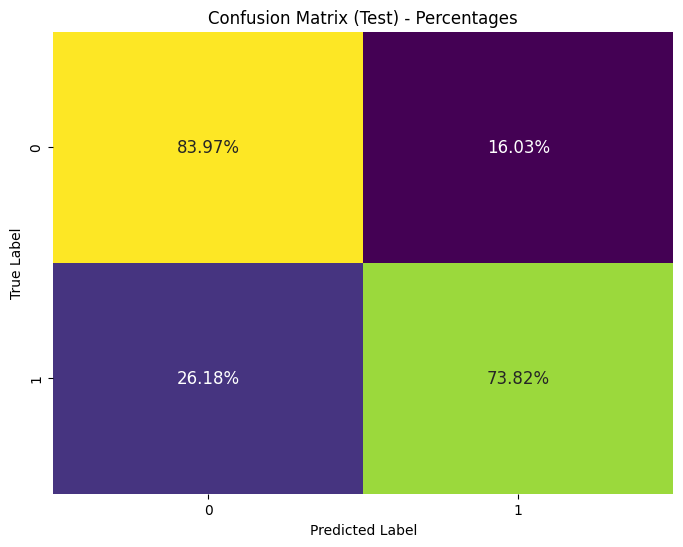

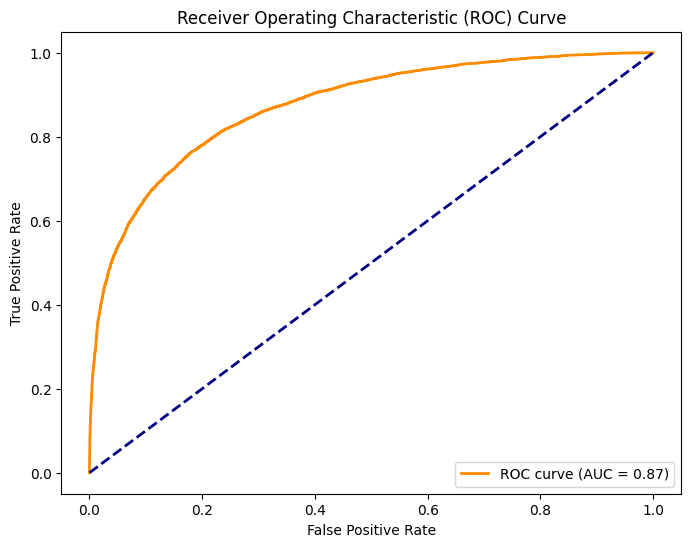

Runtime: 65.23 seconds


In [142]:
# Record time
start_time = time.time()

# Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use StratifiedKFold for cross-validation with stratified sampling
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create and fit the Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(logreg, X_train, y_train, cv=stratified_cv, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

# Fit the model on the entire training set
logreg.fit(X_train, y_train)
# Record time
end_time = time.time()

# Predictions on the training set
y_train_pred = logreg.predict(X_train)

# Predictions on the test set
y_test_pred = logreg.predict(X_test)

# Accuracy Scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Train Accuracy:', train_accuracy)
print('Test Accuracy:', test_accuracy)

# Classification Reports
print('\nTrain Classification Report:\n', classification_report(y_train, y_train_pred))
print('\nTest Classification Report:\n', classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix_test)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix_test / conf_matrix_test.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict probabilities for ROC curve
y_test_prob = logreg.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate AUC score
roc_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print("Runtime: {:.2f} seconds".format(runtime))

Takeaways: 

Train Accuracy: 0.7918, Test Accuracy: 0.7927
- The log model is achieving around 79.2% accuracy on the training set and 79.3% accuracy on the test set.
- The test accuracy is similar to the training accuracy, suggesting that the log model generalizes reasonably well to new, unseen data.

Train Classification Report:
- For class 0 (negative), precision is 79%, recall is 84%, and F1-score is 821
        - Precision (79%): Out of all instances predicted as Class 0, 79% were correctly predicted. This means the model has a relatively low rate of false positives for Class 0.
        - Recall (84%): Out of all actual instances of Class 0, the model correctly identified 84% of them. This indicates a good ability to capture actual negatives
        - F1-Score (81%): The F1-Score, which balances precision and recall, is 82%. This suggests a good overall performance for predicting instances of Class 0.
    - For Class 0, the model is slightly better at recall (capturing actual negatives) than precision (avoiding false positives).
- For class 1 (positive), precision is 80%, recall is 74%, and F1-score is 77%.
    - Class 1 (Positive Class):
        - Precision (80%): Out of all instances predicted as Class 1, 80% were correctly predicted. This means the model has a relatively low rate of false positives for Class 1.
        - Recall (74%): Out of all actual instances of Class 1, the model correctly identified 74% of them. This indicates a good ability to capture actual positives, although it's somewhat lower than Class 0.
        - F1-Score (77%): The F1-Score, which balances precision and recall, is 77%. This suggests a good overall performance for predicting instances of Class 1.
    - For Class 1, the model is slightly better at precision (avoiding false positives) than recall (capturing actual positives).


Confusion Matrix (Test):
- It indicates that the log model is performing well in correctly predicting both classes, but it has some false positives and false negatives.

An AUC of 0.87 suggests that the model is performing well, with a high probability of ranking a randomly chosen positive instance higher than a randomly chosen negative instance. It's a positive sign that the model is effective in distinguishing between the classes.

Cross Validation Scores:
- The model is performing consistently well across different folds, as indicated by the relatively small variance in the cross-validation scores.
- The mean cross-validation accuracy gives an estimate of the expected accuracy of the model on new, unseen data. In this case, it's around 78.9%.

---
**Optimizing the Logistic Regression**

The log model has a decent accuracy, but further analysis might be needed to understand and potentially improve its performance, especially in terms of reducing false positives and false negatives

In order to optimize this logreg model, let's approach the problem with the following steps:
- Let's first see if using oversampling (balancing the classes) will improve the model.
- Then let's apply Recursive Feature Elimination (RFE) or some form of feature elimination to only use the most relevant features that affect our target variable.

Class distribution before oversampling:
disposition
0    45721
1    38780
Name: count, dtype: int64

Class distribution after oversampling:
disposition
0    45721
1    45721
Name: count, dtype: int64
Cross-Validation Scores: [0.78549948 0.78172672 0.78794838 0.78461286 0.77898075]
Mean CV Accuracy: 0.7837536392585134

Test Accuracy: 0.7884597178831771

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80     11348
           1       0.77      0.77      0.77      9778

    accuracy                           0.79     21126
   macro avg       0.79      0.79      0.79     21126
weighted avg       0.79      0.79      0.79     21126


Confusion Matrix (Test):
 [[9127 2221]
 [2248 7530]]


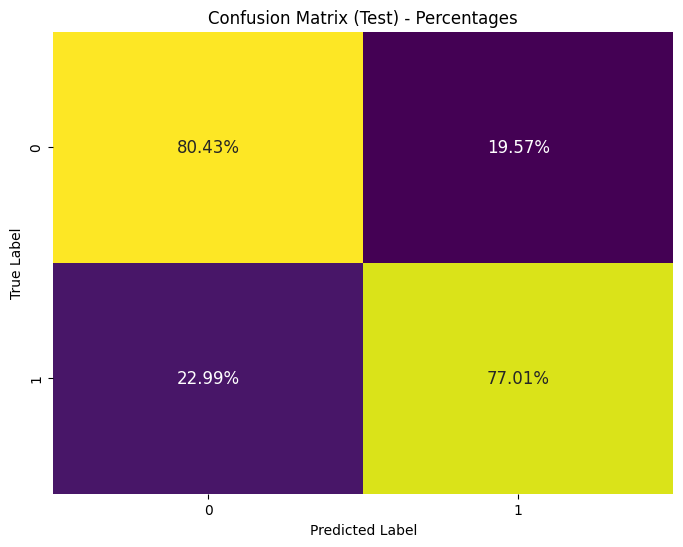

Runtime: 95.58 seconds


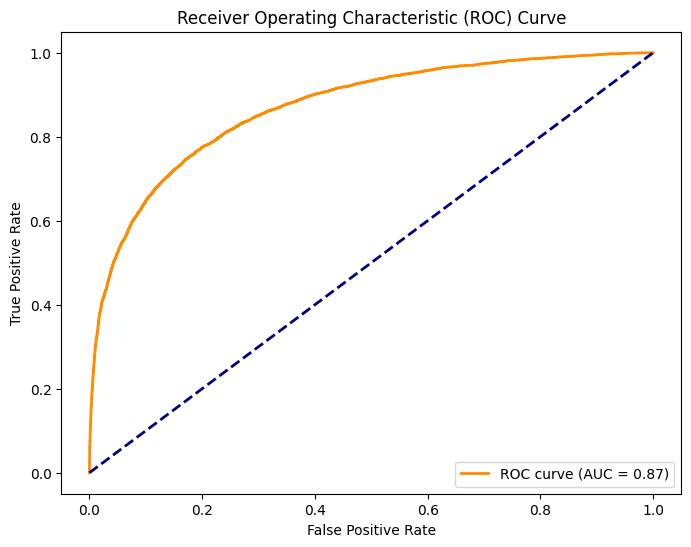

In [ ]:
# Record time
start_time = time.time()

# Check the class distribution before oversampling
print('Class distribution before oversampling:')
print(y_train.value_counts())

# Oversampling using SMOTE
oversampler = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print('\nClass distribution after oversampling:')
print(y_train_oversampled.value_counts())

# Use StratifiedKFold for cross-validation with stratified sampling
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create and fit the Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Perform cross-validation on oversampled data
cv_scores = cross_val_score(logreg, X_train_oversampled, y_train_oversampled, cv=stratified_cv, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

# Train your model on the oversampled data
logreg.fit(X_train_oversampled, y_train_oversampled)

# Record time
end_time = time.time()

# Predictions on the test set
y_test_pred = logreg.predict(X_test)

# Evaluate the model
print('\nTest Accuracy:', accuracy_score(y_test, y_test_pred))
print('\nClassification Report:\n', classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix_test)

# Create a heatmap with the percentages
conf_matrix_percent = conf_matrix_test / conf_matrix_test.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict probabilities for ROC curve
y_test_prob = logreg.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate AUC score
roc_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Calculate runtime
runtime = end_time - start_time
print("Runtime: {:.2f} seconds".format(runtime))

Comparison:
- Accuracy: The accuracy is slightly lower after oversampling, but the classes are now balanced.
- Precision: Precision for Class 0 has increased, but for Class 1, it has decreased slightly.
- Recall: Recall for both classes is more balanced after oversampling.
- F1-Score: F1-Score is comparable between the two scenarios.

CV Interpretation:
- The model is showing consistent performance across different folds, with a relatively small variance in the cross-validation scores.
- The mean cross-validation accuracy suggests an estimated overall accuracy of around 78.4%.

Comparing it to the previous set of results:
- The mean cross-validation accuracy is slightly lower in this case (78.4% compared to 78.9%).
- However, the differences are relatively small, and both models seem to have similar performance.

In general, after oversampling the classes are now balanced but performance is not that different from the baseline model. 
________

**Feature Elimination**

Now moving onto feature elimination, RFE attempts has been too computationally intensive. Instead, I will run a lasso regression to do some feature selection, any one that hits 0 first will be removed from the train/test data set. 

In [ ]:
health_data.shape[1]

437

We will be starting with 437 features. Let's first see what kind of hyper parameters might help the log model perform better. Let's find the best C value. We will be sure to continue to use the oversampled train x and y.

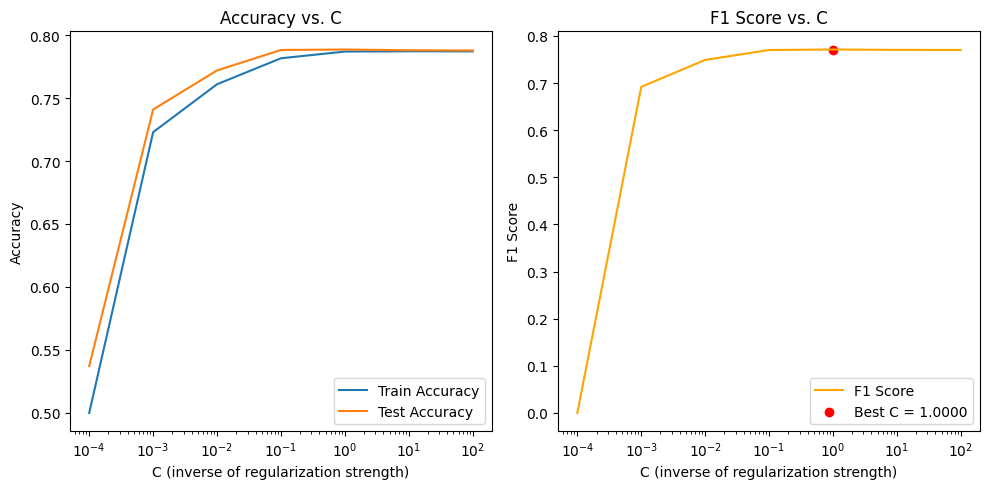

Best C value: 1.0
Runtime: 7.71 seconds


In [ ]:
# Record time
start_time = time.time()

# Range of C values to test
C_values = np.logspace(-4, 2, 7)

# Lists to store accuracy and F1 score
train_accuracy = []
test_accuracy = []
f1_scores = []

# Variable to store the best C value
best_C = None
best_f1_score = 0  # Initialize with a low value

# Loop through each C value
for C_val in C_values:
    # Create a logistic regression model with L1 penalty
    estimator_l1 = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', C=C_val)

    # Train the model
    estimator_l1.fit(X_train_oversampled, y_train_oversampled)

    # Predict on the training set
    y_train_pred = estimator_l1.predict(X_train_oversampled)

    # Predict on the test set
    y_test_pred = estimator_l1.predict(X_test)

    # Calculate accuracy for training and test sets
    train_accuracy.append(accuracy_score(y_train_oversampled, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_test_pred))

    # Calculate F1 score for the test set
    f1 = f1_score(y_test, y_test_pred)
    f1_scores.append(f1)

    # Update best C value if needed
    if f1 > best_f1_score:
        best_f1_score = f1
        best_C = C_val

# Plot the results
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(C_values, train_accuracy, label='Train Accuracy')
plt.plot(C_values, test_accuracy, label='Test Accuracy')
plt.xscale('log')
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. C')

# Plot F1 score
plt.subplot(1, 2, 2)
plt.plot(C_values, f1_scores, label='F1 Score', color='orange')
plt.scatter(best_C, best_f1_score, color='red', marker='o', label=f'Best C = {best_C:.4f}')
plt.xscale('log')
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Score vs. C')

plt.tight_layout()
plt.show()

# Print the best C value
print(f"Best C value: {best_C}")

# Record time
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time
print("Runtime: {:.2f} seconds".format(runtime))

It was found that the best C value was 1.0. We will implement this into the next iteration of the log model as well as using the oversampled (but balanced) train data. 

In [ ]:
# Record  time
start_time = time.time()

# Choose logistic regression with L1 regularization (penalty='l1')
estimator_l1 = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear',C = 1.0)

# Fit logistic regression with L1 regularization on oversampled training data for the subset
estimator_l1.fit(X_train_oversampled, y_train_oversampled)
# Record time
end_time = time.time()

# Get the coefficients and corresponding feature names
coefficients_l1 = estimator_l1.coef_[0]
feature_names = X.columns

# Get indices of features with non-zero coefficients
non_zero_indices_l1 = np.where(coefficients_l1 != 0)[0]

print(f'The total number of relevant columns is:{non_zero_indices_l1.shape}') #Find the number of features left after feature selection

# Print the features with non-zero coefficients
print("\nFeatures with Non-Zero Coefficients (L1 Regularization):")
for idx in non_zero_indices_l1:
    print(f"Feature: {feature_names[idx]}, Coefficient: {coefficients_l1[idx]}")


# Calculate runtime
runtime = end_time - start_time
print("Runtime: {:.2f} seconds".format(runtime))



The total number of relevant columns is:(418,)

Features with Non-Zero Coefficients (L1 Regularization):
Feature: demo_gender, Coefficient: 0.05269878913058466
Feature: demo_race, Coefficient: 0.17915379179303198
Feature: pmh_2ndarymalig, Coefficient: 0.4842174962103608
Feature: pmh_abdomhernia, Coefficient: 0.022233227106980405
Feature: pmh_acqfootdef, Coefficient: -0.11339806448566507
Feature: pmh_acrenlfail, Coefficient: 0.18546761201486636
Feature: pmh_acutecvd, Coefficient: 0.06906046350591842
Feature: pmh_acutemi, Coefficient: -0.003579016312653994
Feature: pmh_acutphanm, Coefficient: 0.1268955256789383
Feature: pmh_adltrespfl, Coefficient: 0.03899001244503825
Feature: pmh_alcoholrelateddisorders, Coefficient: 0.20683794806994066
Feature: pmh_anemia, Coefficient: 0.15119848081808032
Feature: pmh_aneurysm, Coefficient: 0.01320229144410801
Feature: pmh_anxietydisorders, Coefficient: -0.07368645532105715
Feature: pmh_asppneumon, Coefficient: 0.11641904399657735
Feature: pmh_asthma, 

In [ ]:
#Isolate irrelevant columns 
irrelevant_columns = health_data.columns.difference(feature_names[non_zero_indices_l1])

# Ensure 'disposition' is not in the irrelevant columns
irrelevant_columns = irrelevant_columns.difference(['disposition'])

# Display the number of irrelevant columns and their names
num_irrelevant_columns = len(irrelevant_columns)
print(f"Number of irrelevant columns: {num_irrelevant_columns}")
print("Irrelevant columns:", irrelevant_columns)

Number of irrelevant columns: 18
Irrelevant columns: Index(['cc_exposuretostd', 'cc_hemoptysis', 'cc_tachycardia', 'pmh_amniosdx',
       'pmh_artembolism', 'pmh_comabrndmg', 'pmh_dminpreg', 'pmh_encephalitis',
       'pmh_guconganom', 'pmh_lowbirthwt', 'pmh_maintchemr', 'pmh_mycoses',
       'pmh_otitismedia', 'pmh_prevcsectn', 'pmh_rheumarth', 'pmh_tonsillitis',
       'pmh_urinyorgca', 'pmh_uteruscancr'],
      dtype='object')


In [ ]:
health_data = health_data.drop(columns=irrelevant_columns) #dropping irrelevant columns

In [ ]:
health_data.shape[1]#columns have been successfully dropped 

419

After we evaluate the log reg coefficients with lasso, there are a total of 19 features that were removed. We will remove these from the original dataframe, then run the log reg model once more with the over-sampled data. 

Cross-Validation Scores: [0.78418722 0.7827656  0.7878937  0.7845035  0.78012905]
Mean CV Accuracy: 0.7838958119771089
Train Accuracy: 0.7869031735963781

Train Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79     45721
           1       0.80      0.77      0.78     45721

    accuracy                           0.79     91442
   macro avg       0.79      0.79      0.79     91442
weighted avg       0.79      0.79      0.79     91442


Confusion Matrix (Train):
 [[36705  9016]
 [10470 35251]]


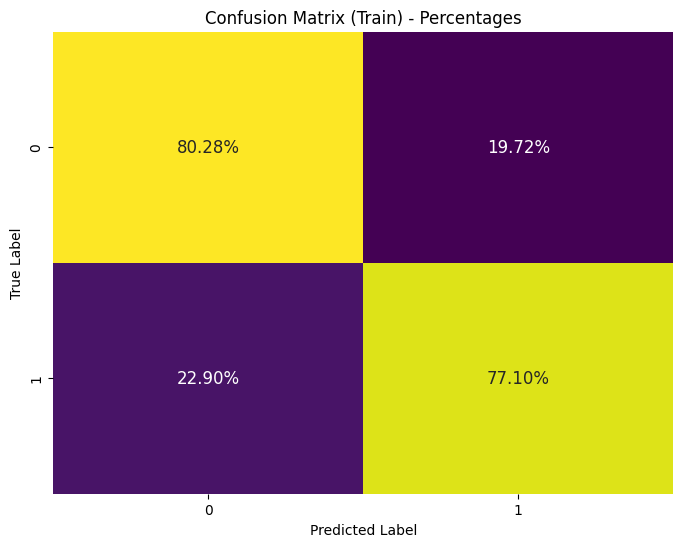


Test Accuracy: 0.788933068257124

Test Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80     11348
           1       0.77      0.77      0.77      9778

    accuracy                           0.79     21126
   macro avg       0.79      0.79      0.79     21126
weighted avg       0.79      0.79      0.79     21126


Confusion Matrix (Test):
 [[9131 2217]
 [2242 7536]]


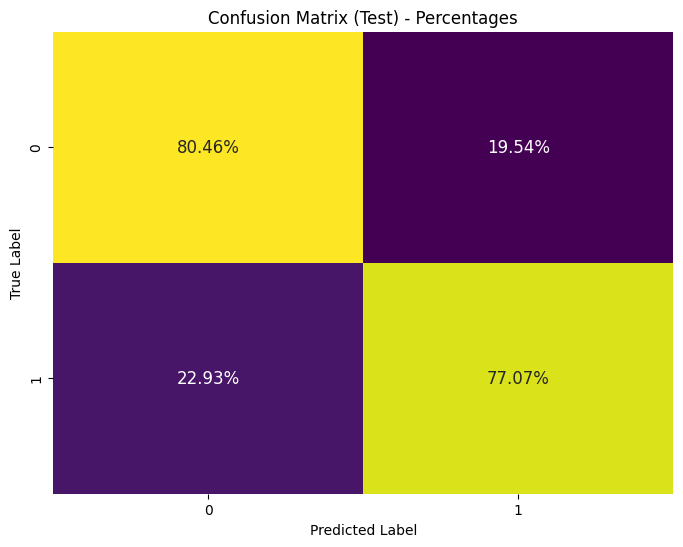

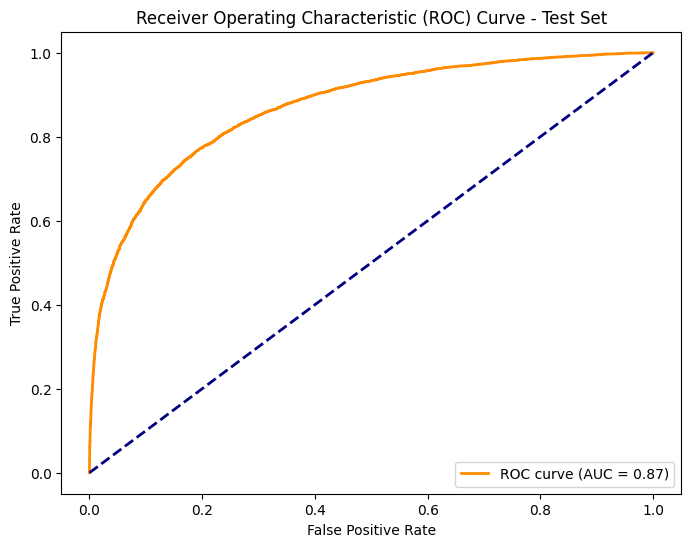

Runtime: 43.42 seconds


In [ ]:
# Record time
start_time = time.time()

# Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Split to train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversampling using SMOTE
oversampler = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Use StratifiedKFold for cross-validation with stratified sampling
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train your final logistic regression model using the selected features on the training set
final_logreg_model = LogisticRegression(C=1.0, max_iter=1000, penalty='l1', solver='liblinear', random_state=42)

# Perform cross-validation on oversampled data
cv_scores = cross_val_score(final_logreg_model, X_train_oversampled, y_train_oversampled, cv=stratified_cv, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

# Fit the final model on the entire oversampled training set
final_logreg_model.fit(X_train_oversampled, y_train_oversampled)

# Record time
end_time = time.time()

# Make predictions on the training set
y_train_pred = final_logreg_model.predict(X_train_oversampled)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train_oversampled, y_train_pred)

print('Train Accuracy:', train_accuracy)

# Classification Reports for training set
print('\nTrain Classification Report:\n', classification_report(y_train_oversampled, y_train_pred))

# Confusion Matrix for training set
conf_matrix_train = confusion_matrix(y_train_oversampled, y_train_pred)
print('\nConfusion Matrix (Train):\n', conf_matrix_train)

# Calculate percentages for the confusion matrix on the training set
conf_matrix_percent_train = conf_matrix_train / conf_matrix_train.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_train, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Train) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Make predictions on the test set
y_test_pred = final_logreg_model.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)

print('\nTest Accuracy:', test_accuracy)

# Classification Reports for test set
print('\nTest Classification Report:\n', classification_report(y_test, y_test_pred))

# Confusion Matrix for test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix_test)

# Calculate percentages for the confusion matrix on the test set
conf_matrix_percent_test = conf_matrix_test / conf_matrix_test.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_test, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict probabilities for ROC curve on the test set
y_test_prob = final_logreg_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate AUC score on the test set
roc_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print("Runtime: {:.2f} seconds".format(runtime))

The model shows similar performance on both the training and test sets, suggesting that it generalizes well to unseen data.
- Accuracy: The model is correct around 78.7% of the time on both the training and test sets.
- Precision, recall, and F1-score are balanced for both classes, indicating a good trade-off between precision and recall.
- The model tends to perform slightly better on the negative class (0), as indicated by higher precision, recall, and F1-score for this class in both training and test sets.

CV Interpretation:
- The cross-validation scores range from approximately 0.780 to 0.788.
- The mean cross-validation accuracy is approximately 0.784.

Comparison with the previous model:

- The mean cross-validation accuracy is slightly higher in this case (78.4% compared to 78.4%). The difference is very small, and both models seem to have similar performance.


When comparing the baseline model to the optimized model, there is little noticeable difference/improvement in terms of accuracy. If anything, it's performing slightly worse than the baseline model. 
____

In order to reserve computational intensity, I will be doing a RandomSearch instead of a GridSearch. This way, the log model will be fully optimized. 

Best Hyperparameters: {'C': 95.07243064099163}
Cross-Validation Scores: [0.78599158 0.78292963 0.78685477 0.78455818 0.78018373]
Mean CV Accuracy: 0.7841035769771493
Train Accuracy: 0.7870781478970276

Train Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.80      0.79     45721
           1       0.80      0.77      0.78     45721

    accuracy                           0.79     91442
   macro avg       0.79      0.79      0.79     91442
weighted avg       0.79      0.79      0.79     91442


Confusion Matrix (Train):
 [[36661  9060]
 [10410 35311]]


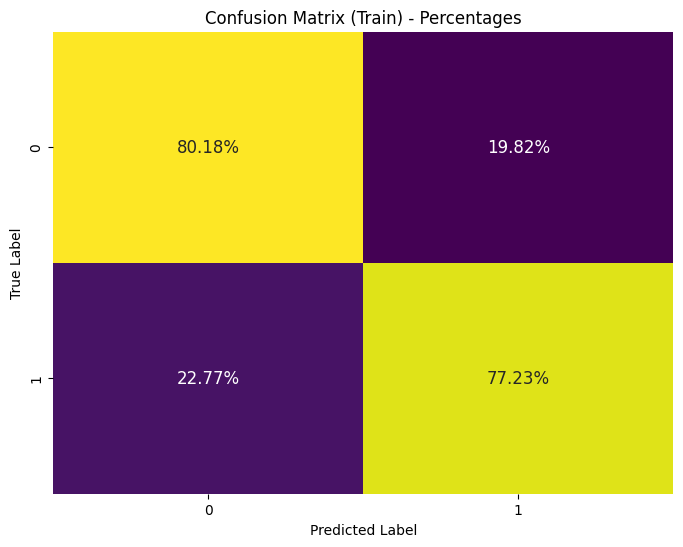


Test Accuracy: 0.7878443623970462

Test Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80     11348
           1       0.77      0.77      0.77      9778

    accuracy                           0.79     21126
   macro avg       0.79      0.79      0.79     21126
weighted avg       0.79      0.79      0.79     21126


Confusion Matrix (Test):
 [[9118 2230]
 [2252 7526]]


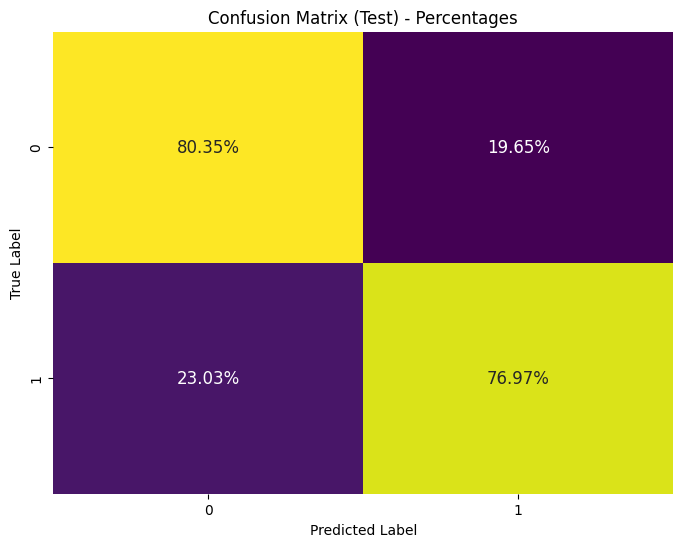

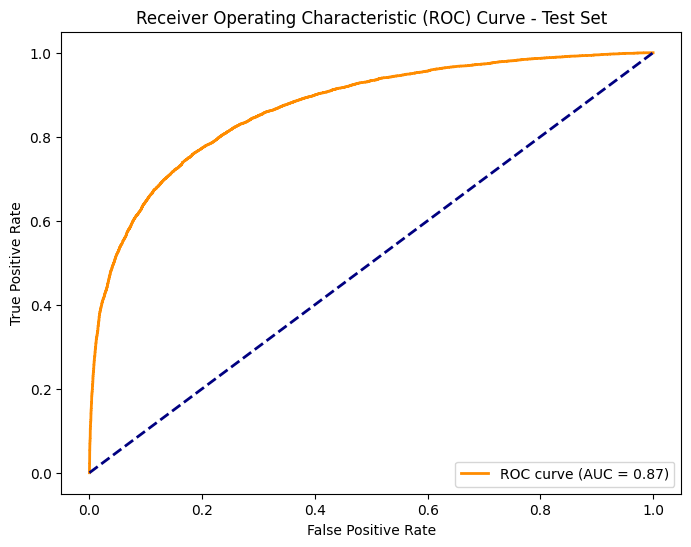

Runtime: 84.49 seconds


In [ ]:
# Record time
start_time = time.time()

# Define the hyperparameter distribution
param_dist = {'C': uniform(0.001, 100)}

# Create logistic regression model
logreg = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', random_state=42)

# Use StratifiedKFold for cross-validation with stratified sampling
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Randomized Search with 5-fold cross-validation
random_search = RandomizedSearchCV(logreg, param_distributions=param_dist, n_iter=10, cv=stratified_cv, scoring='accuracy', random_state=42)
random_search.fit(X_train_oversampled, y_train_oversampled)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_logreg_model = random_search.best_estimator_
final_logreg_model.fit(X_train_oversampled, y_train_oversampled)

# Record time
end_time = time.time()

# Evaluate the model using cross-validation
cv_scores = cross_val_score(final_logreg_model, X_train_oversampled, y_train_oversampled, cv=stratified_cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Print the results
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", mean_cv_accuracy)

# Make predictions on the training set
y_train_pred = final_logreg_model.predict(X_train_oversampled)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train_oversampled, y_train_pred)
print('Train Accuracy:', train_accuracy)

# Classification Reports for training set
print('\nTrain Classification Report:\n', classification_report(y_train_oversampled, y_train_pred))

# Confusion Matrix for training set
conf_matrix_train = confusion_matrix(y_train_oversampled, y_train_pred)
print('\nConfusion Matrix (Train):\n', conf_matrix_train)

# Calculate percentages for the confusion matrix on the training set
conf_matrix_percent_train = conf_matrix_train / conf_matrix_train.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_train, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Train) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Make predictions on the test set
y_test_pred = final_logreg_model.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print('\nTest Accuracy:', test_accuracy)

# Classification Reports for test set
print('\nTest Classification Report:\n', classification_report(y_test, y_test_pred))

# Confusion Matrix for test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix_test)

# Calculate percentages for the confusion matrix on the test set
conf_matrix_percent_test = conf_matrix_test / conf_matrix_test.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_test, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict probabilities for ROC curve on the test set
y_test_prob = final_logreg_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate AUC score on the test set
roc_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()


# Calculate runtime
runtime = end_time - start_time
print("Runtime: {:.2f} seconds".format(runtime))

As we can see, not too much has changed even after running for optimal hyperparameters. If anything, the accuracy score decreased ever so slightly. 

However, when comparing CV scores, it seems that the current set of results has slightly higher cross-validation scores and a marginally higher mean cross-validation accuracy compared to the prior set. This indicates that, on average, the current set of hyperparameters or model configurations may be performing slightly better across different folds in the cross-validation process.


---
#### <a id = 'tree'></a> 1.3 Decision Tree

I plan to also do random forest down the road as an advanced model. It would be a good idea to have a baseline with just a simple decision tree. I will run a base decision tree then run with hyperparameter optimized to see if I can improve it's overall performance. 


Cross-Validation Scores (5-fold): [0.71599314 0.70869822 0.72071006 0.71426036 0.71514793]
Mean CV Accuracy (5-fold): 0.7149619409096272

Test Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.75      0.74     11348
           1       0.70      0.69      0.70      9778

    accuracy                           0.72     21126
   macro avg       0.72      0.72      0.72     21126
weighted avg       0.72      0.72      0.72     21126


Confusion Matrix (Test):
 [[8478 2870]
 [3017 6761]]


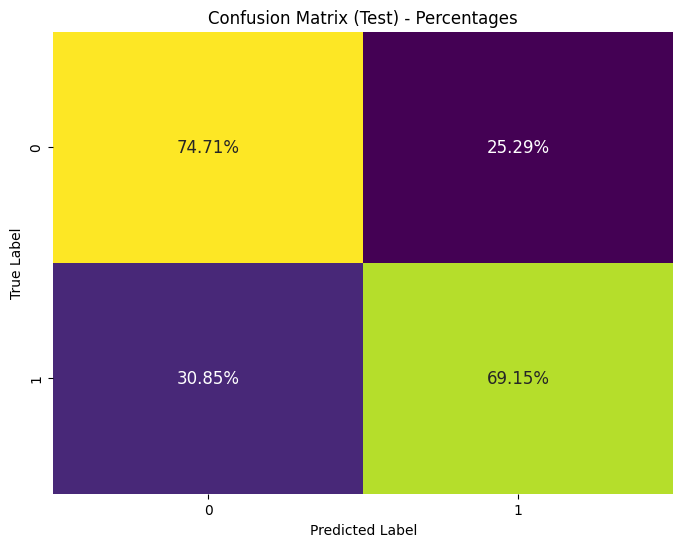

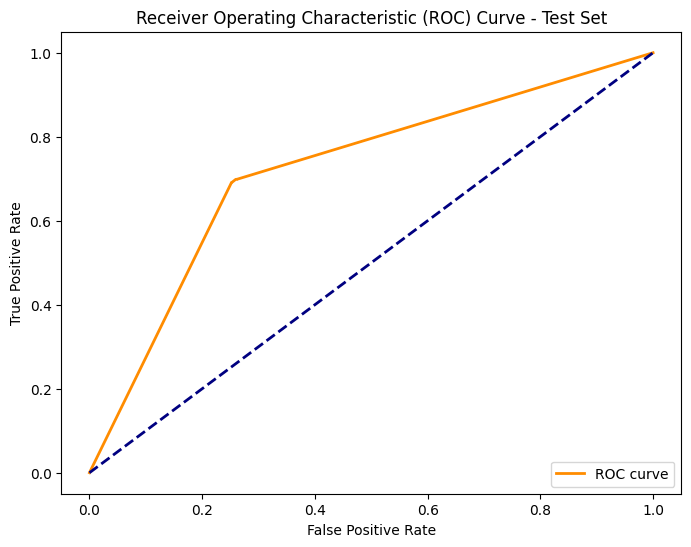

Runtime: 5.02 seconds


In [ ]:
# Record time
start_time = time.time()

# Create a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
dt_model.fit(X_train, y_train)

# Record time
end_time = time.time()

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Display cross-validation results
print("\nCross-Validation Scores (5-fold):", cv_scores)
print("Mean CV Accuracy (5-fold):", mean_cv_accuracy)

# Classification Report
print('\nTest Classification Report:\n', classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, dt_model.predict_proba(X_test)[:, 1])

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print("Runtime: {:.2f} seconds".format(runtime))


In summary, the decision tree model has a moderate level of accuracy, with a trade-off between precision and recall. 

The Cross Validation test shows that the model could be more sensitive to specific to each fold. On average, the model predicts with a 71.5% accuracy across different folds. 

Now let's try to optimize it's performance.

/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklear

Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy'}
Test Accuracy: 0.7522041642436339

Cross-Validation Scores (5-fold): [0.74812141 0.7556213  0.76029586 0.74934911 0.74763314]
Mean CV Accuracy (5-fold): 0.7522041642436339

Test Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.84      0.79     11348
           1       0.78      0.66      0.72      9778

    accuracy                           0.76     21126
   macro avg       0.76      0.75      0.75     21126
weighted avg       0.76      0.76      0.76     21126


Confusion Matrix (Test):
 [[9581 1767]
 [3335 6443]]


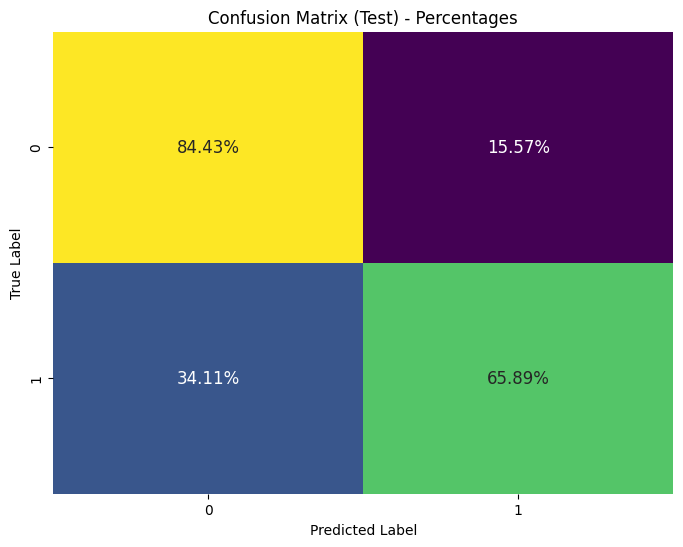

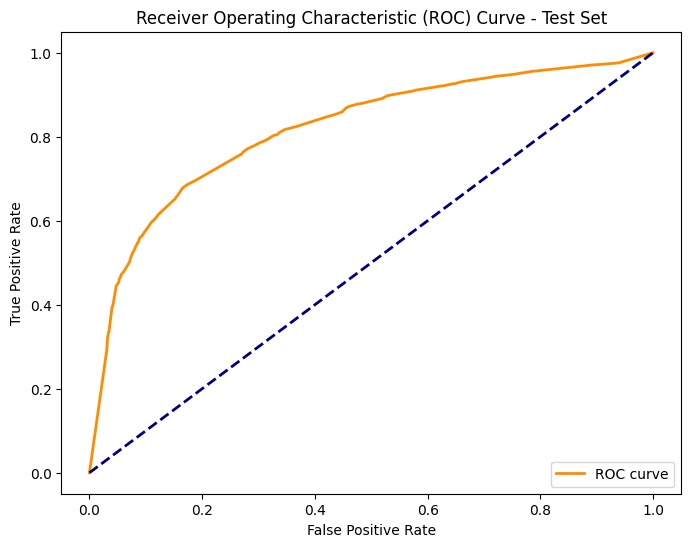

Runtime: 236.11 seconds


In [ ]:
# Record time
start_time = time.time()

# Create a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Define a broader hyperparameter grid
param_dist = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

# Use StratifiedKFold for cross-validation with stratified sampling
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV Object
random_search = RandomizedSearchCV(dt_model, param_distributions=param_dist, n_iter=50,
                                   cv=stratified_cv, scoring='accuracy', random_state=42)

# Fit to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", random_search.best_params_)
print("Test Accuracy:", random_search.best_score_)

# Get the best model
best_dt_model = random_search.best_estimator_

# Predict on the test set
y_pred = best_dt_model.predict(X_test)

# Perform 5-fold cross-validation using StratifiedKFold
cv_scores = cross_val_score(best_dt_model, X_train, y_train, cv=stratified_cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)

# Display cross-validation results
print("\nCross-Validation Scores (5-fold):", cv_scores)
print("Mean CV Accuracy (5-fold):", mean_cv_accuracy)

# Classification Report
print('\nTest Classification Report:\n', classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, best_dt_model.predict_proba(X_test)[:, 1])

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

# Record time
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time
print("Runtime: {:.2f} seconds".format(runtime))


Key takeaways: 
Precision: 
- For class 0, precision is 0.73, and for class 1, it is 0.81. This means that when the model predicts a class, it's correct about 73% of the time for class 0 and 81% for class 1.
Recall (Sensitivity): 
- For class 0, recall is 0.87, and for class 1, it is 0.62. This means that the model is good at capturing the majority of instances for class 0 (87%) but not as good for class 1 (62%).
F1-Score: 
- For class 0, F1-score is 0.79, and for class 1, it is 0.70.

Crossvaildation: 
- Performance is relatively similar across all folds.

In general the model appears to have good accuracy but the log regression still performs better. 

---
### <a id = 'conc'></a> Conclusion

Now that we have ran our basic models and optimized them, we can see that in general they perform pretty similarly with logistic regression performing slightly better in comparison to decision tree. Even after running several iterations to optimize performance, the accuracy score hovers around 80%. We will now export these base models so that they can be used on new unseen data. 

The model for logistic regression

In [ ]:
from joblib import dump, load

# Save the model
dump(final_logreg_model, 'KLO_BStn_LogReg.joblib')

# Load the model
loaded_model = load('KLO_BStn_LogReg.joblib')


The model for Decision Tree

In [ ]:
from joblib import dump, load

# Save the model
dump(best_dt_model, 'KLO_BStn_DTree.joblib')

# Load the model
best_dt_model = load('KLO_BStn_DTree.joblib')


In [ ]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 419 entries, demo_gender to dum_huse__3-plus_hormones
dtypes: int8(419)
memory usage: 42.2 MB


As we will continue our advanced model in a separate notebook, we will export another CSV file.

In [ ]:
health_data.to_csv('clean_health_data_pt3.csv', index=False) 

----